In [1]:
import numpy as np
import glob
import open3d as o3d
import matplotlib.pyplot as plt
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data Fusion in Computer Vision

Data fusion in computer vision refers to the technique of integrating data from multiple sensor modalities to enhance tasks such as 3D object detection. There are two principal approaches to data fusion:

- **Early Fusion (Data-Level or Feature-Level Fusion)**: This strategy involves merging raw data from different sensors at the beginning of the processing pipeline. The consolidated data is then analyzed using algorithms or Deep Neural Networks (DNNs). Early fusion is particularly effective in capturing the dynamics between different types of sensor data early in the processing stage.

- **Late Fusion (Decision-Level Fusion)**: In late fusion, data from each sensor is processed independently using algorithms or DNNs. The individual outputs are then combined to form a final decision. This approach is beneficial when it's important to analyze sensor data separately before integrating their results.

### The Logic of Data Fusion

Data fusion is grounded in the principle that different sensors have distinct strengths and can offset each other's weaknesses. For example:

- **LiDAR Sensors**: These are unparalleled in depth perception and distance estimation, outperforming stereo cameras. However, LiDAR can struggle under adverse weather conditions and typically involves higher costs related to resolution. Additionally, LiDAR data is often sparse, offering limited semantic detail about a scene.

- **Cameras**: Cameras excel in object classification and spatial resolution. They provide rich, detailed information about a scene's content, which is essential for understanding and interpreting the environment. Nonetheless, camera performance can also degrade in poor weather.

- **Radar Sensors**: Renowned for their robust velocity estimation, radar sensors are less affected by weather conditions and can provide valuable data, especially in motion analysis.

By integrating data from these varied sources, we can develop more comprehensive and effective AI solutions for computer vision tasks. Each sensor compensates for the limitations of others, enabling a more nuanced and detailed understanding of the environment. This fusion approach is particularly powerful as it leverages the unique capabilities of each sensor type, providing a holistic view that is greater than the sum of its parts.

In this tutorial, we will explore data fusion using two specific modalities from the KITTI dataset: the Velodyne HDL-64E LiDAR and the 1.4 Megapixels Point Grey Flea 2 (FL2-14S3C-C) Color Camera.

### Sensors in the KITTI Dataset:
- `1` Inertial Navigation System (GPS/IMU): OXTS RT 3003
- `1` Laserscanner: Velodyne HDL-64E
- `2` Grayscale Cameras (1.4 Megapixels): Point Grey Flea 2 (FL2-14S3M-C)
- `2` Color Cameras (1.4 Megapixels): Point Grey Flea 2 (FL2-14S3C-C)
- `4` Varifocal Lenses (4-8 mm): Edmund Optics NT59-917


## Projection from Lidar 3D Space to Image 2D Pixel Space
A crucial aspect of early fusion is projecting points from the LiDAR's 3D coordinate frame (`x, y, z`) onto corresponding 2D pixel coordinates (`x, y`) in the image space. This projection is key to integrating spatial and visual data, enhancing the accuracy of object detection systems.


# Kitti Sensor Setup

Below is the overall view of how all the sensors where setup in the kitty dataset. 

![Point Cloud Visualization](../Doc_Images/DATAFUSION_DOC_IMAGES/kitty_setup.png)

## Projection of LiDAR Data onto Camera Images

Projecting LiDAR data onto camera images necessitates a careful consideration of the differences in their coordinate systems. Let's analyze the coordinate systems in terms of unit vectors for the KITTI dataset senso in the image to the rightrs:

- **Coordinate System of Color Camera `Cam 2`**:
  - **X-axis Unit Vector**: Points upwards.
  - **Y-axis Unit Vector**: Points into the page (perpendicular to the image plane).
  - **Z-axis Unit Vector**: Points to the left (parallel to the image plane).

- **Coordinate System of Velodyne Laserscanner (LiDAR)**:
  - **X-axis Unit Vector**: Points to the left.
  - **Y-axis Unit Vector**: Points downwards.
  - **Z-axis Unit Vector**: Points out of the page (perpendicular to the LiDAR scanning plane).

The physical displacement between these sensors is also a crucial factor, with a separation of approximately 0.27 meters.

### Steps for Accurate 3D to 2D Projection
To map the 3D LiDAR point cloud data onto the 2D camera image plane effectively, the following transformations are necessary:

1. **Coordinate System Alignment**:
   - Apply a Rotation Matrix that aligns the LiDAR's unit vectors (`x, y, z`) with those of the camera. This step ensures that the directional orientation of both systems is consistent.

2. **Translation Adjustment**:
   - Implement a Translation Vector to account for the physical offset between the LiDAR and the camera. This translation corresponds to the real-world displacement and is crucial for accurate overlaying of 3D points onto the 2D image.

By executing these transformations, we can accurately project LiDAR point cloud data onto the camera's image plane, ensuring spatial and directional fidelity between the two sensor modalities.


## Projecting LiDAR Data onto Camera Images

Accurately projecting LiDAR data onto camera images involves more than just determining the rotation and translation matrices between the LiDAR sensor and the camera. It's essential to consider both the intrinsic and extrinsic properties of the camera.

### Camera Calibration and Intrinsic Matrix
Camera calibration is crucial as it determines the intrinsic properties of the camera. The resulting intrinsic calibration matrix is represented as:

$$
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

Here, \(f_x\) and \(f_y\) are the focal lengths along the X and Y axes, respectively, while \(c_x\) and \(c_y\) represent the optical center of the camera. The camera's ability to project 3D objects onto a 2D image introduces distortions and other parameters that must be accounted for.

### Extrinsic Properties
The extrinsic properties, such as the camera's position and orientation in the world, are also vital.

### Consideration for Vehicle Placement
Note: Placing the camera inside a vehicle, such as behind the windshield, introduces additional distortion. The calibration process should consider this factor.

### Stereo Vision and Rectification
For stereo vision systems, the Stereo Rectification Matrix, a 3x3 matrix, aligns the images from two cameras. If stereo vision is not used, this matrix defaults to the identity matrix.

## Projection Formula
To derive a 2D pixel coordinate from a 3D LiDAR point, we use the following projection formula:

$$
Y = P \cdot R_0 \cdot [R | t] \cdot X
$$

Where:
- \(Y\) is the 2D pixel coordinate (Nx2 matrix, N being the number of points).
- \(P\) is a 3x4 matrix containing the 3x3 intrinsic matrix and a 1x4 extrinsic vector.
- \(R_0\) is the 3x3 Stereo Rectification Matrix.
- \([R | t]\) is a 3x4 matrix combining rotation and translation from the LiDAR to the camera coordinate frame.
- \(X\) is an Nx3 matrix of 3D points from the LiDAR sensor.

Enough talk lets do some coding before moving on


In [2]:
#Lets first load the data
lidar_data_path = "../DATA/lidar_data/*.pcd"
lidar_file_names = sorted(glob.glob(lidar_data_path))
print(lidar_file_names[0:3])

['../DATA/lidar_data\\0000000000.pcd', '../DATA/lidar_data\\0000000001.pcd', '../DATA/lidar_data\\0000000002.pcd']


Let us load the calibration files from the kitty data set

In [3]:
#Set path for camera extrinsic and intrinsic vectors and matrices
camera_calibration_path = "../DATA/calibrations/calib_cam_to_cam.txt"
#Set path for rotation and translation matrix from velodyne to camera
velodyne_to_camera_calibration_path = "../DATA/calibrations/calib_velo_to_cam.txt"

In [4]:
#Let us review the camera calibration file
#We will also use the regex library re for parsing. 
"""
In the cam_to_cam file we need camera 2 those are the images we have in our DATA folder.
These images are not setero. What we need to extract is P_rect_02 and R_rect_02
"""
import re
P_pattern = "P_rect_02"
R_0_pattern = "R_rect_02"

P = None
R_0 = None

with open(camera_calibration_path) as file:
    for line in file:
        try:
            #First see if it is P using re.search
            if re.search(P_pattern, line):
                #lets split line at spaces and end of line \n
                split_list = re.split(f'[ \n]', line)
                #Remove first element and last to contain just numbers
                split_list.pop(0)
                split_list.pop(-1)
                float_numbers = [float(number) for number in split_list]
                #Convert to numpy array and reshape to (3, 4 matrix)
                P = np.array(float_numbers).reshape(3,4)
                print(f"Matrix P {P.shape}:")
                print(P)
            #Second see if it is R using re.search
            elif re.search(R_0_pattern, line):
                #lets split line at spaces and end of line \n
                split_list = re.split(f'[ \n]', line)
                #Remove first element and last to contain just numbers
                split_list.pop(0)
                split_list.pop(-1)
                float_numbers = [float(number) for number in split_list]
                #Convert to numpy array and reshape to (3, 3 matrix)
                R_0 = np.array(float_numbers).reshape(3,3)
                print(f"Matrix R0 {R_0.shape}:")
                print(R_0)
        except ValueError as ve:
            print(f"ValueError occurred: {ve}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

Matrix R0 (3, 3):
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix P (3, 4):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]


Notice how Matrix R0 has values close to 1 on its diagonal and values close to zero everywhere else. This is becuase we are not using stereo imagery, thus the R0 value is the identity matrix or its approximation

In [5]:
#Let us now get the velodyne calibration

#Define Rotation and Translation matrices to look for
R_pattern = "R:"
t_pattern = "T:"

R = None
t = None
with open(velodyne_to_camera_calibration_path) as file:
    for line in file:
        try:
            #First see if it is R using re.search
            if re.search(R_pattern, line):
                #lets split line at spaces and end of line \n
                split_list = re.split(f'[ \n]', line)
                #Remove first element and last to contain just numbers
                split_list.pop(0)
                split_list.pop(-1)
                float_numbers = [float(number) for number in split_list]
                #Convert to numpy array and reshape to (3, 4 matrix)
                R = np.array(float_numbers).reshape(3,3)
                print(f"Matrix R {R.shape}:")
                print(R)
            #Second see if it is T using re.search
            elif re.search(t_pattern, line):
                #lets split line at spaces and end of line \n
                split_list = re.split(f'[ \n]', line)
                #Remove first element and last to contain just numbers
                split_list.pop(0)
                split_list.pop(-1)
                float_numbers = [float(number) for number in split_list]
                #Convert to numpy array and reshape to vector
                t = np.array(float_numbers).reshape(-1,1)
                print(f"Vector t {t.shape}:")
                print(t)
        except ValueError as ve:
            print(f"ValueError occurred: {ve}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    #Let us now combine the rotation translation vector to give us R_t 3x4 
    R_t = np.concatenate((R, t), axis=1)
    print(f"Matrix R|t {R_t.shape}:")
    print(R_t)
del R
del t

Matrix R (3, 3):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
Vector t (3, 1):
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]
Matrix R|t (3, 4):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


## Understanding LiDAR-Camera Calibration

![Lidar Camera Calibration](../Doc_Images/DATAFUSION_DOC_IMAGES/lidar_camera_calibration.png)

How exactly are these matrices calculated in practice?

The process of LiDAR-camera calibration is intricate and goes beyond the scope of this lesson, yet grasping its fundamental concept is essential. Primarily, calibration involves establishing a geometric relationship between the LiDAR and camera coordinate systems. This is commonly achieved through the following methods:

### Feature Extraction Using Checkerboards
- A checkerboard with known square dimensions is used. 
- During calibration, an image and a corresponding LiDAR scan are taken to identify the checkerboard corners.
- These corners and planes, extracted from both the camera and LiDAR data, help to establish the necessary coordinate alignment.

### Alternate Not So Good Method: Correspondence-Based Calibration
- This method involves collecting a set of LiDAR points and their corresponding 2D pixel points in the camera image.
- The projection from LiDAR to camera can be represented as:

  $$
  Y = P \cdot R_0 \cdot [R | t] \cdot X
  $$

  This equation can be simplified to:

  $$
  Y = A \cdot X
  $$

  Where \( A \) is the unknown matrix, and \( X \) and \( Y \) are known. Techniques like least squares or gradient descent can be applied to minimize the error between the actual \( Y \) values and the predicted \( Y' \) values, thereby estimating \( A \).

### LiDAR-Camera Calibration in Matlab
Matlab offers a robust implementation for LiDAR and camera calibration, providing all necessary matrices for projecting from 3D space to 2D pixel space. More information can be found here: [Matlab LiDAR and Camera Calibration](https://www.mathworks.com/help/lidar/ug/lidar-and-camera-calibration.html).

## Time Synchronization
Ensuring accurate calibration requires precise time synchronization between image and LiDAR data. Variations in the scanning frequencies of these sensors can lead to alignment issues. Typically, the most effective method for synchronization is to align images and LiDAR scans using the nearest matching timestamps. The higher the scanning frequency of each sensor, the greater the likelihood of achieving precise alignment. While software-based synchronization techniques are commonly used and provide a practical solution, they are not entirely free from errors. In applications where precision is paramount, hardware-based synchronization is advisable for simultaneous data capture and alignment. Fortunately, in our case, we have access to the synchronized dataset from KITI, which simplifies this aspect of the process.


## Homogeneous Coordinates in Matrix Multiplication

You might have noticed an intriguing detail in matrix projection formula. Consider the projection matrix formula:

$$
Y = P \cdot R_0 \cdot [R | t] \cdot X
$$

Breaking it down, we have:

$$
Y_{N \times 2} = P_{3x4} \cdot R_{0_{3x3}} \cdot [R | t]_{3x4} \cdot X_{N \times 3}
$$

A crucial observation here is the challenge in multiplying `P` and `R0` due to their mismatched dimensions, as the rules of matrix multiplication require the inner dimensions to match (i.e., 3x4 @ 3x3 is not feasible). Also, `R|t` and `X` have mismatched dimensions. To resolve this, we employ homogeneous coordinates, which involve augmenting our matrices to ensure compatible dimensions for multiplication. This conversion is key to project from 3D LiDAR points to 2D image space.


## Homogeneous Coordinates 
Homogeneous coordinates are a system of coordinates utilized in projective geometry and computer graphics. They extend traditional Cartesian coordinates by adding an additional dimension, enabling the representation of geometric transformations such as translation, rotation, and scaling in a unified manner. This is particularly useful for various matrix operations, like projecting data from LiDAR to camera space, by converting matrices to homogeneous coordinates to ensure compatibility in dimensions for matrix multiplication.

### Conversion to Homogeneous Coordinates

- **2D Euclidean Point:**
  For a point in 2D Cartesian coordinates,
  $$
  \begin{bmatrix}
  x \\
  y 
  \end{bmatrix}
  $$
  its conversion to homogeneous coordinates involves adding a third dimension. Typically, this third dimension is represented as \( w \), which can be any non-zero scalar value. A common choice for  `w` is 1, resulting in:
  $$
  \begin{bmatrix}
  x \\ 
  y \\ 
  w
  \end{bmatrix}
  $$
  where  `w` is typically set to 1 for practical purposes, but it can be any non-zero value.

- **3D Euclidean Point:**
  Similarly, a point in 3D Cartesian coordinates,
  $$
  \begin{bmatrix}
  x \\ y \\ z
  \end{bmatrix}
  $$
  is extended in homogeneous coordinates by adding a fourth dimension, usually set to 1:
  $$
  \begin{bmatrix}
  x \\ y \\ z \\ w
  \end{bmatrix}
  $$
  where, as in the 2D case, `w` is typically 1 but can be any non-zero scalar.

### From Euclidean to Homogeneous Matrix Representation

- **3D Points Matrix (Euclidean Space):**
  For our lidar matrix of `N` 3D points in Euclidean space,
  $$
  \begin{bmatrix}
  x_1 & y_1 & z_1 \\
  x_2 & y_2 & z_2 \\
  \vdots & \vdots & \vdots \\
  x_N & y_N & z_N
  \end{bmatrix}
  $$
  the homogeneous representation extends each point with an additional dimension where `w` is set to 1:
  $$
  \begin{bmatrix}
  x_1 & y_1 & z_1 & 1\\
  x_2 & y_2 & z_2 & 1\\
  \vdots & \vdots & \vdots & \vdots\\
  x_N & y_N & z_N & 1
  \end{bmatrix}
  $$

### Rotation Matrix in Homogeneous Coordinates

- **3x3 Rotation Matrix (Euclidean Coordinates):**
  The standard 3x3 rotation matrix in Euclidean coordinates, 
  $$
  \begin{pmatrix}
  \cos\beta\cos\gamma & -\cos\beta\sin\gamma & \sin\beta \\
  \cos\alpha\sin\gamma + \cos\gamma\sin\alpha\sin\beta & \cos\alpha\cos\gamma - \sin\alpha\sin\beta\sin\gamma & -\cos\beta\sin\alpha \\
  \sin\alpha\sin\gamma - \cos\alpha\cos\gamma\sin\beta & \cos\gamma\sin\alpha + \cos\alpha\sin\beta\sin\gamma & \cos\alpha\cos\beta
  \end{pmatrix}
  $$
  is expanded in homogeneous coordinates as a 3x4 to incorporate the possibility of translations, resulting in:
  $$
  \begin{pmatrix}
  \cos\beta\cos\gamma & -\cos\beta\sin\gamma & \sin\beta \\
  \cos\alpha\sin\gamma + \cos\gamma\sin\alpha\sin\beta & \cos\alpha\cos\gamma - \sin\alpha\sin\beta\sin\gamma & -\cos\beta\sin\alpha  \\
  \sin\alpha\sin\gamma - \cos\alpha\cos\gamma\sin\beta & \cos\gamma\sin\alpha + \cos\alpha\sin\beta\sin\gamma & \cos\alpha\cos\beta  \\
  0 & 0 & 0
  \end{pmatrix}
  $$


or if we wanted to make this  a 4x4 matrix

  $$
  \begin{pmatrix}
  \cos\beta\cos\gamma & -\cos\beta\sin\gamma & \sin\beta & 0 \\
  \cos\alpha\sin\gamma + \cos\gamma\sin\alpha\sin\beta & \cos\alpha\cos\gamma - \sin\alpha\sin\beta\sin\gamma & -\cos\beta\sin\alpha & 0 \\
  \sin\alpha\sin\gamma - \cos\alpha\cos\gamma\sin\beta & \cos\gamma\sin\alpha + \cos\alpha\sin\beta\sin\gamma & \cos\alpha\cos\beta  & 0\\
  0 & 0 & 0 & 1
  \end{pmatrix}
  $$

## Converting LiDAR and Camera Calibration Matrices to Homogeneous Coordinates

Consider the following matrix equation representing a transformation involving LiDAR and camera calibration:
$$
Y_{N \times 2} = P_{3 \times 4} \cdot R_{0_{3 \times 3}} \cdot [R | t]_{3 \times 4} \cdot X_{N \times 3}
$$

To adapt this equation for homogeneous coordinates, we modify the dimensions of the involved matrices:
$$
Y = P_{3 \times 4} \cdot R_{0_{4 \times 3}} \cdot [R | t]_{3 \times 4} \cdot X_{N \times 4}
$$

However, it's necessary to transpose the matrix \( X \) to match the dimensions for multiplication:
$$
Y = P_{3 \times 4} \cdot R_{0_{4 \times 3}} \cdot [R | t]_{3 \times 4} \cdot X_{4 \times N}
$$

Proceeding with the matrix multiplication, we obtain:
$$
A_{3 \times 3} = P_{3 \times 4} \cdot R_{0_{4 \times 3}}
$$

Then, we multiply by the rotation and translation matrix:
$$
B_{3 \times 4} = A_{3 \times 3} \cdot [R | t]_{3 \times 4}
$$

Finally, we arrive at the transformed matrix:
$$
Y_{3 \times N} =  B_{3 \times 4} \cdot X_{4 \times N}
$$

## Converting Back to Euclidean Coordinates

The matrix \( Y \) is currently \( 3 \times N \) in dimensions, indicating that it is a 2D representation in homogeneous coordinates. To convert \( Y \) back to a Euclidean 2D representation, we normalize each point by its third coordinate. This conversion is illustrated as follows:

**Homogeneous Coordinates**
$$
\begin{bmatrix}
x \\ y \\ w
\end{bmatrix}
$$
**Euclidean Coordinates**
$$
\begin{bmatrix}
x/w \\ y/w
\end{bmatrix}
$$


Alright let us go step by step on converting each matrix to its homogenous representation to carry out the projection! 


In [38]:
#Let us first convert R_0 to its homogenous representation
print(f"Matrix R_0 {R_0.shape}")
print(R_0)
#Let us add the extra dimension only zeros since we are just expanidng row dimension
R_0_homogenous = np.concatenate((R_0, np.array([[0,0,0]])), axis=0)
print(f"Matrix R_0_homogenous {R_0_homogenous.shape}")
print(R_0_homogenous) 

Matrix R_0 (3, 3)
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix R_0_homogenous (4, 3)
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]]


Let us load our X points from our .pcd files

In [39]:
#We will work with the first element
lidar_file = lidar_file_names[0]
print(lidar_file)
#Read lidar file and create pointcloud data for vizualization
point_cloud = o3d.io.read_point_cloud(lidar_file)
#Let us now convert to a numpy array
X = np.asarray(point_cloud.points)
print(f"Matrix X {X.shape}")
print(X)

../DATA/lidar_data\0000000000.pcd
Matrix X (122595, 3)
[[57.38899994  7.92000008  2.16799998]
 [57.47200012  8.02400017  2.171     ]
 [57.5890007   8.22500038  2.17600012]
 ...
 [ 3.67499995 -1.38999999 -1.71599996]
 [ 3.70900011 -1.38900006 -1.73099995]
 [ 3.60599995 -1.33700001 -1.67700005]]


In this case N is 122,595 points 

In [40]:
#Let us now convert to homogenous coordinates
X_homogenous = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
print(f"Matrix X homogenous {X_homogenous.shape}")
print(X_homogenous)

Matrix X homogenous (122595, 4)
[[57.38899994  7.92000008  2.16799998  1.        ]
 [57.47200012  8.02400017  2.171       1.        ]
 [57.5890007   8.22500038  2.17600012  1.        ]
 ...
 [ 3.67499995 -1.38999999 -1.71599996  1.        ]
 [ 3.70900011 -1.38900006 -1.73099995  1.        ]
 [ 3.60599995 -1.33700001 -1.67700005  1.        ]]


In [41]:
#however we really need X to be in dimensions 4xN
X_homogenous_transpose = X_homogenous.T
print(X_homogenous_transpose.shape)

(4, 122595)


Lets see if this works and we can carry out the matrix multiplication use `@` for matrix multiplication in numpy

In [42]:
# we will tranpose the final output to get back N, 3 dimension
Y_homogenous = (P@R_0_homogenous@R_t@X_homogenous_transpose).T
print(Y_homogenous.shape)

(122595, 3)


In [44]:
#Let us now convert it to euclidean pixels using element wise division in numpy

#Let us first
Y = Y_homogenous[:, 0:2] / Y_homogenous[:, 2].reshape(-1,1)

Lets functionalize this and create a function that returns the Y coordinates

In [45]:
def project_points(P, R_0, R_t, X):
    #Convert to homogenous coord
    R_0_homogenous = np.concatenate((R_0, np.array([[0,0,0]])), axis=0)
    X_homogenous = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    #Transpose X
    X_homogenous_transpose = X_homogenous.T
    #Peform matrix multiplication
    Y_homogenous = (P@R_0_homogenous@R_t@X_homogenous_transpose).T

    return Y_homogenous[:, 0:2] / Y_homogenous[:, 2].reshape(-1,1)
    
    

In [46]:
Y = project_points(P, R_0, R_t, X)
print(Y.shape)

(122595, 2)


It worked now let us look at the images 

In [47]:
#Lets first load the data
image_data_path = "../DATA/image_02/data/*.png"
image_file_names = sorted(glob.glob(image_data_path))
print(image_file_names[0:3])

['../DATA/image_02/data\\0000000000.png', '../DATA/image_02/data\\0000000001.png', '../DATA/image_02/data\\0000000002.png']


In [48]:
#Let us make sure we have the same number of lidar files to images
print(len(lidar_file_names) == len(image_file_names))

#Make sure we are working with the same lidar and corresponding image 
print(lidar_file)

image_file = image_file_names[0]

print(image_file)



True
../DATA/lidar_data\0000000000.pcd
../DATA/image_02/data\0000000000.png


All good to go let us load and explore the image, we will be using cv2 note that cv2 loads the images in BGR and must be converted back to RGB

(375, 1242, 3)


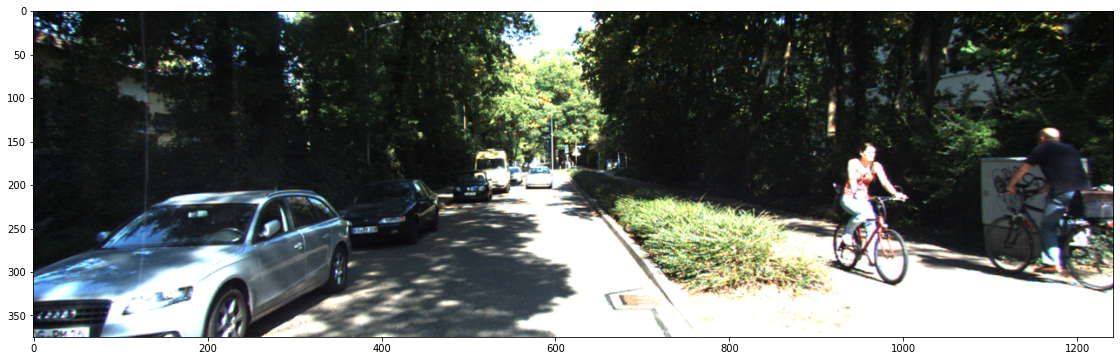

In [49]:
#Load image in RGB
img = cv2.cvtColor(cv2.imread(image_file),  cv2.COLOR_BGR2RGB)
#Let see the image dimensions
print(img.shape)
#Display image
plt.figure(figsize=(20, 6))
plt.imshow(img)

Let us again observe the Y projection of lidar point unto the image plane

In [50]:
#Let us check out the x dimensions
print(Y[:, 0].max(), Y[:, 0].min())
#Now the y
print(Y[:, 1].max(), Y[:, 1].min())

15258119.044836631 -31330743.72120284
8973041.97994487 -1459562.9313802512


## Understanding Pixel Coordinates Beyond Image Limits

We've encountered a scenario where some pixel coordinates extend beyond the boundaries of our image. Let's consider the image dimensions:

- Minimum X (xmin) = 0
- Minimum Y (ymin) = 0
- Maximum X (xmax) = 1242
- Maximum Y (ymax) = 375

This phenomenon occurs due to the limited field of view (FoV) of the camera, both vertically and horizontally. In contrast, our LiDAR sensor provides a 360-degree horizontal FoV. As a result, certain points that are either behind the camera or at the far edges of its periphery can still be detected by the LiDAR.

When these points are projected onto the pixel space, they fall outside the camera's FoV. This is why we see pixel coordinates that are beyond the limits of our image dimensions.

Additionally, it's important to note that as we transform data from 3D (LiDAR) to 2D (image), points that are distinct in depth but close in lateral position might be projected to the same pixel location. This 'squishing' effect from 3D to 2D can lead to overlapping points in the image space, further complicating the interpretation of these coordinates.

### Let us now project our lidar points to the image! 

In [51]:
#First we must extact our xmin, ymin, xmax, ymax image dimensiosn
xmin, ymin, xmax, ymax = 0, 0 , img.shape[1], img.shape[0]
print(xmin, ymin, xmax, ymax)

0 0 1242 375


In [52]:
#Now let us subset the Y matrix to get those that fall into image space or FOV of the camera 
Y_in_fov = Y[np.where(((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <= ymax)
                      ))[0]]

In [53]:
#Lets print out the number of points left
print(Y_in_fov.shape)
#Let us check out the x dimensions
print(Y_in_fov[:, 0].max(), Y_in_fov[:, 0].min())
#Now the y
print(Y_in_fov[:, 1].max(), Y_in_fov[:, 1].min())

(40091, 2)
1241.9853318852608 0.007446219879161722
374.9741316223757 0.023136154698328235


Yes now have all points that are within the FOV of the camera, let us use this to project them unto the image

In [54]:
#create a copy of the image
img_copy = img.copy()

#Iterate over points and raw a cirrcle with a specifeid radius
#Lets make the points red
color = (0,0,255)
radius = 1

for point in Y_in_fov:
    #Convert coordinate to ints
    x, y = int(point[0]), int(point[1])
    #Draw point
    cv2.circle(img_copy, (x,y), radius, color, -1) # -1 fills the circle

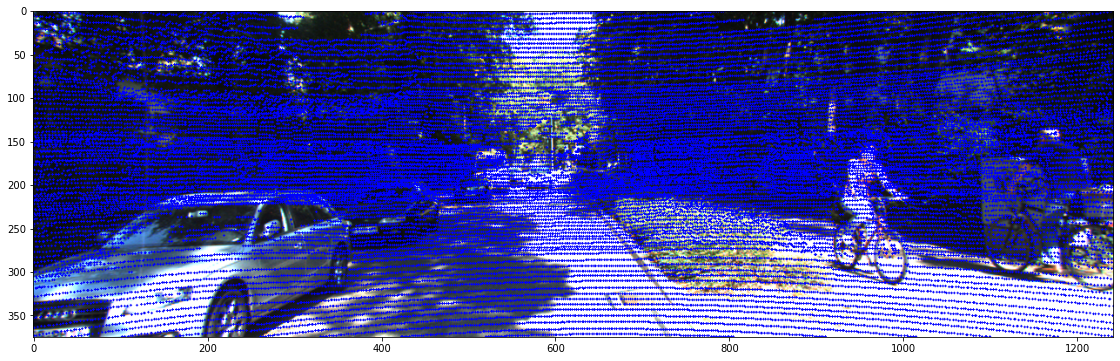

In [55]:
plt.figure(figsize=(20, 6))
plt.imshow(img_copy)

## Assessing the Projection Effectiveness

Determining the success of our projection can be challenging, especially if there are numerous points to consider. To simplify the analysis, let's consider the alignment of the LiDAR and camera. Given that the LiDAR's X-axis vector aligns with the camera's viewing direction, any points with negative X-coordinates (in the LiDAR's perspective) would fall outside the camera's field of view. These points are essentially extraneous for our purpose.

To address this, we can filter out these negative X-coordinate points. This will help in isolating only the relevant points that are within the camera's field of view, potentially making it easier to evaluate the projection's accuracy.


In [56]:
print(X.shape)
#Get points in the +x direction only 180 degrees
X_180_fov = X[np.where(X[:, 0] >= 0)[0]]
print(X_180_fov.shape)

(122595, 3)
(60881, 3)


In [57]:
#Now lets project these points using our function
Y = project_points(P, R_0, R_t, X_180_fov)
print(Y.shape)
#Now let us subset the Y matrix to get those that fall into image space or FOV of the camera 
Y_in_fov = Y[np.where(((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <= ymax)
                      ))[0]]
print(Y_in_fov.shape)

(60881, 2)
(19167, 2)


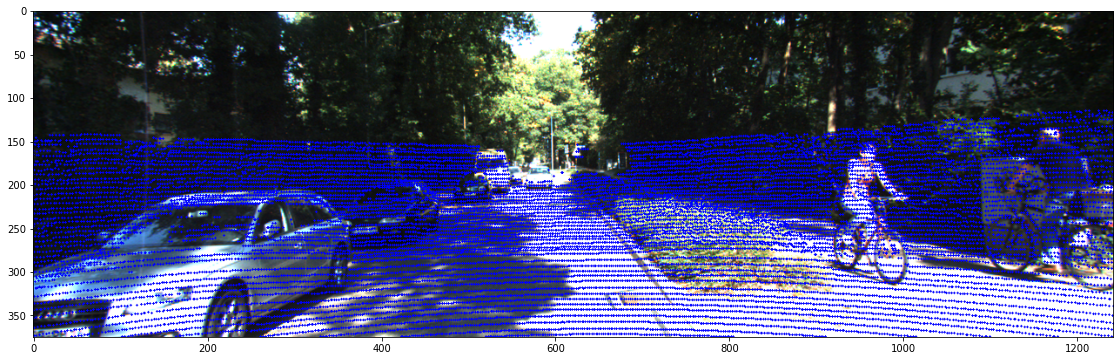

In [58]:
#create a copy of the image
img_copy = img.copy()

#Iterate over points and raw a cirrcle with a specifeid radius
#Lets make the points red
color = (0,0,255)
radius = 1

for point in Y_in_fov:
    #Convert coordinate to ints
    x, y = int(point[0]), int(point[1])
    #Draw point
    cv2.circle(img_copy, (x,y), radius, color, -1) # -1 fills the circle

plt.figure(figsize=(20, 6))
plt.imshow(img_copy)

## Successful Projection and Next Steps

Great news! The projection appears to be functioning correctly, and everything is aligned as expected. To delve deeper and gain a more detailed view, we have an interesting option: removing the ground points. This can be achieved using the RANSAC algorithm, as detailed in the unsupervised section of this repository.

For your convenience, I encapsulated this functionality into a utility function. You can find it in the `data_fusion_utils.py` file located in this same folder. By using this function, we can efficiently filter out the ground points and focus on the more significant aspects of our data. The `project_points` and `visualize_cloud` are also included in this utility script. We won't import these since `project_points` is already defined in this notebook and we have no need to visualize the point cloud at the moment. However, Part II we will use all of these functions and others that have been used in this notebook. Feel free to review the `data_fusion_utils.py` script to understand how to use them. 


In [63]:
#Let import the RANSAC function from this utils
from data_fusion_utils import RANSAC

In [64]:
#Now lets remove the ground points and do voxel down sampling as well
PCD = RANSAC(point_cloud, downsample=True)
#We will now subset the point cloud to thos only within 180 degrees fov front view
PCD_180 = PCD.select_by_index(np.where(np.asarray(PCD.points)[:, 0] >= 0)[0])
#Conver to numpy array 
X_180_fov = np.asarray(PCD_180.points)

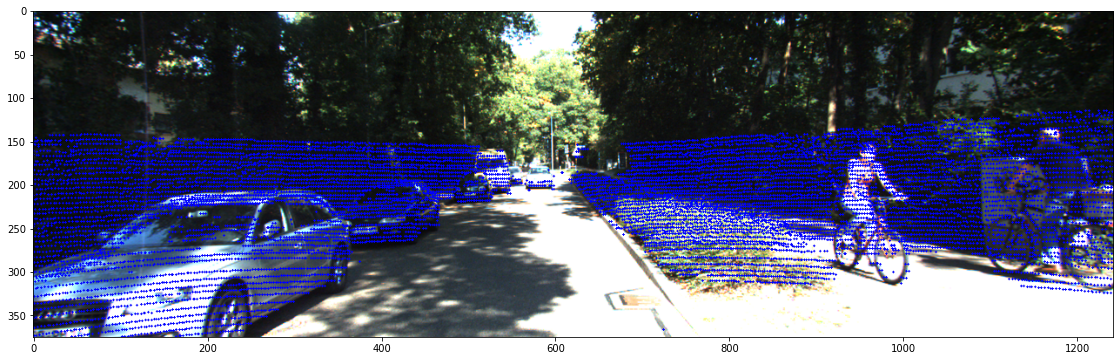

In [65]:
#Now lets project these points using our function
Y = project_points(P, R_0, R_t, X_180_fov)
#Now let us subset the Y matrix to get those that fall into image space or FOV of the camera 
Y_in_fov = Y[np.where(((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <= ymax)
                      ))[0]]


#create a copy of the image
img_copy = img.copy()

#Iterate over points and raw a cirrcle with a specifeid radius
#Lets make the points red
color = (0,0,255)
radius = 1

for point in Y_in_fov:
    #Convert coordinate to ints
    x, y = int(point[0]), int(point[1])
    #Draw point
    cv2.circle(img_copy, (x,y), radius, color, -1) # -1 fills the circle

plt.figure(figsize=(20, 6))
plt.imshow(img_copy)

We see here that the points line up very well with the image! 

# Video Creation

let us now create an output gif of all these files with the camera and lidar projection using RANSAC

In [86]:
#Create a list of gif images 
gif_images = []
for lidar_file, image_file in zip(lidar_file_names, image_file_names):
    #Load point cloud and apply RANSAC function
    point_cloud = RANSAC(o3d.io.read_point_cloud(lidar_file), downsample=True)
    X = np.asarray(point_cloud.points)
    image = cv2.cvtColor(cv2.imread(image_file),  cv2.COLOR_BGR2RGB)
    X_180_fov = X[np.where(X[:, 0] >= 0)[0]]
    #Now lets project these points using our function
    Y = project_points(P, R_0, R_t, X_180_fov)
    #Now let us subset the Y matrix to get those that fall into image space or FOV of the camera 
    Y_in_fov = Y[np.where(((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <= ymax)
                          ))[0]]
    
    
    #create a copy of the image
    img_copy = image.copy()
    
    #Iterate over points and raw a cirrcle with a specifeid radius
    #Lets make the points red
    color = (0,0,255)
    radius = 1
    
    for point in Y_in_fov:
        #Convert coordinate to ints
        x, y = int(point[0]), int(point[1])
        #Draw point
        cv2.circle(img_copy, (x,y), radius, color, -1) # -1 fills the circle
    
    #Stack original image on top and the other with the projected lidar points
    gif_images.append(np.vstack((image, img_copy)))
        
    

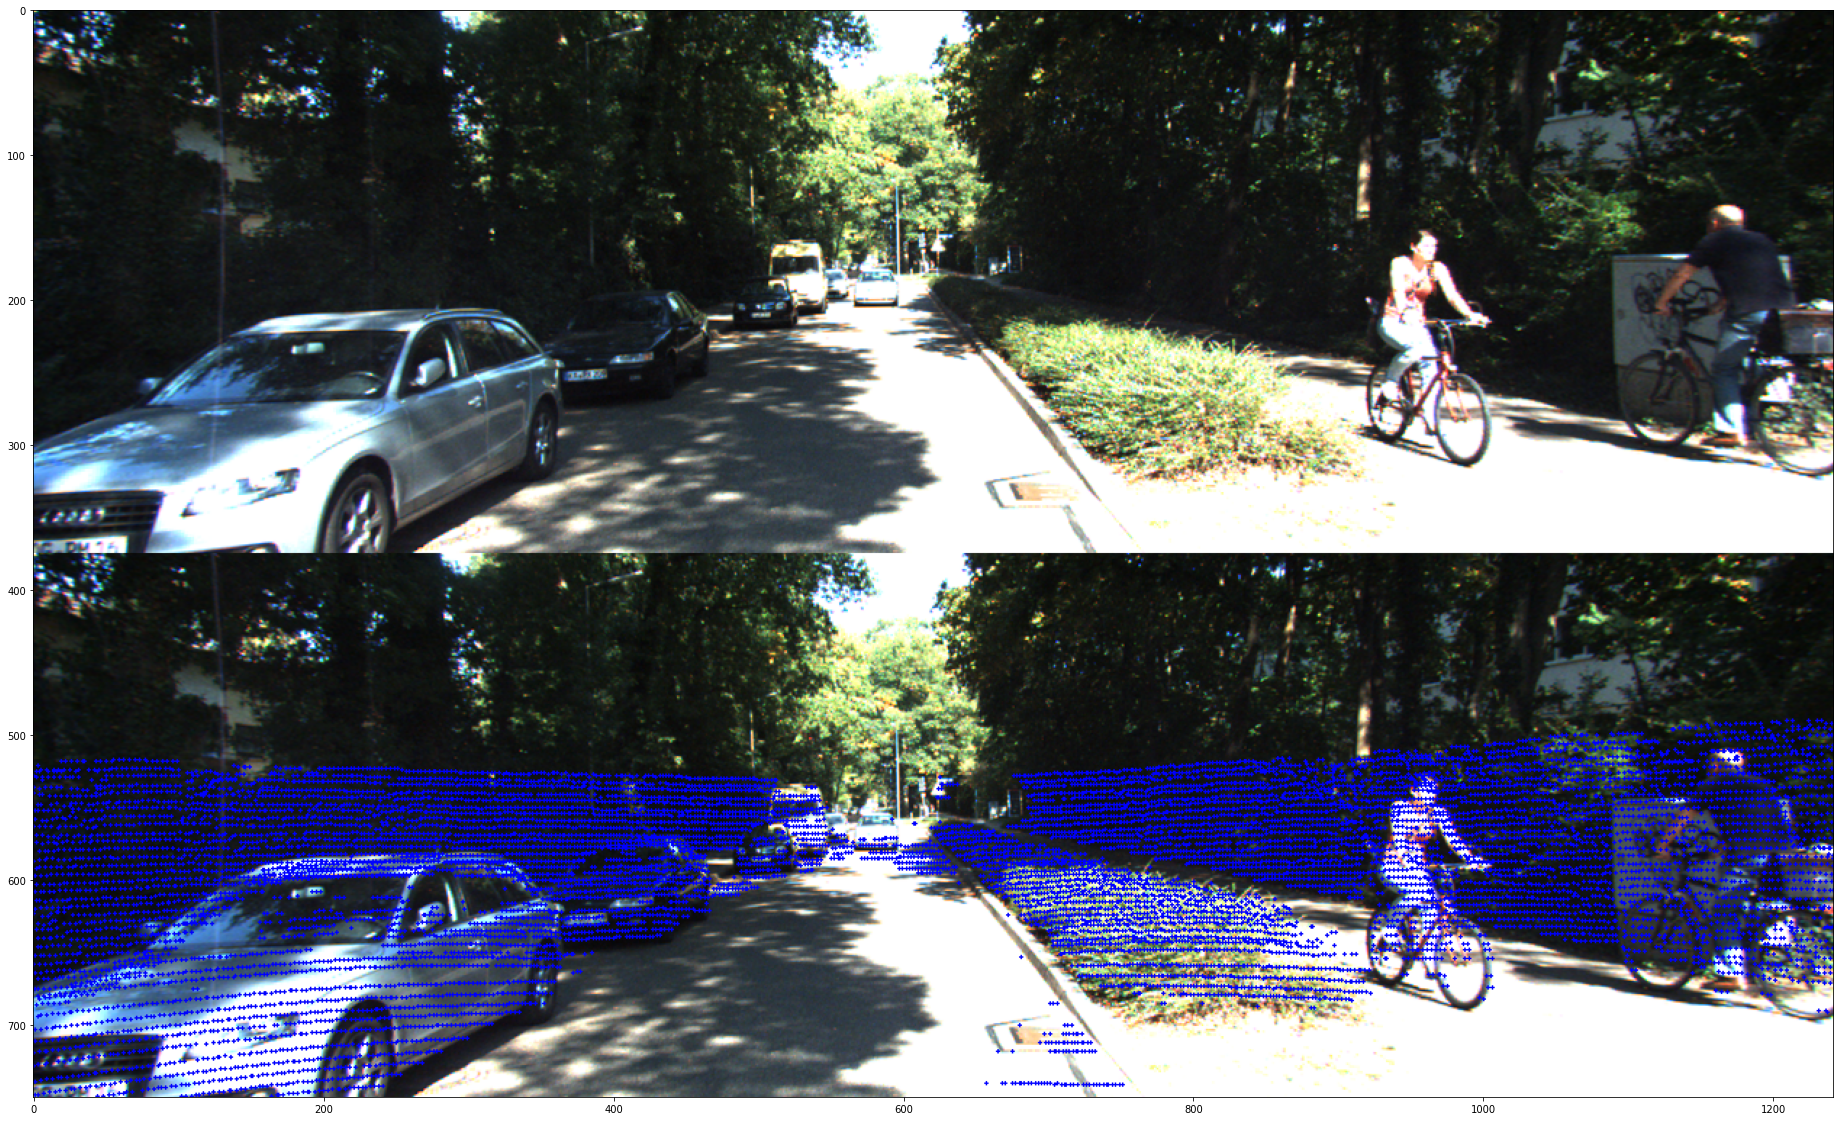

In [87]:
#Let us check out the first image just to make sure 
plt.figure(figsize=(40, 20))
plt.imshow(gif_images[0])

excellent let us now create the gif using imageio

In [88]:
# !pip install imageio

In [89]:
# Save the images as a GIF
import imageio
#Set duration of each each frame 
frame_duration = 1
imageio.mimsave("lidar_projection.gif", gif_images, duration=frame_duration)

# Output

<img src="lidar_projection.gif" alt="Lidar-Camera-Projection" style="loop:infinite;">
